In [127]:
# import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

plt.style.use('ggplot')
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [128]:
# open the USGS tsv file
# data=pd.read_csv('yellowstone.tsv', sep='\t')

# save as csv
# data.to_csv('yellowstone6192500.csv', index=False)

#This was only needed once to convert the tsv to csv

# EDA
This project is an effort to see if the spring increase in discharge can be predicted from publicly available streamflow, snotel, and weather data.

The Yellowstone river was selected as it is an undammed river with readily accessible data. 

The streamflow data is from the Yellowstone river at Livingston MT. The data is from the USGS and is available at https://waterdata.usgs.gov/mt/nwis/uv?site_no=06192500

The snotel data is from nwcc-ftp.cr.usgs.gov and is available at https://www.wcc.nrcs.usda.gov/nwcc/site?sitenum=384
Data for the following site(s) are contained in this file:
	SNOTEL 384: Canyon, WY
	SNOTEL 670: Northeast Entrance, MT
	SNOTEL 683: Parker Peak, WY
	SNOTEL 806: Sylvan Lake, WY
	SNOTEL 816: Thumb Divide, WY


The weather data is from https://www.ncei.noaa.gov/cdo-web/
The data is from the Livingston, MT weather station. The data is available at https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USC00247212/detail
The data is also from the Yellowstone Lake, MT weather station. The data is available at https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USC00247212/detail


In [129]:
# get streamflow data
data=pd.read_csv('yellowstone6192500.csv')

data['datetime'] = pd.to_datetime(data['datetime'])

data.drop(columns=['timezone', 'agency_cd', 'discharge_quality', 'gage_height_quality'], inplace=True)

print(data.head())

/tmp/ipykernel_159329/1663773499.py:2: DtypeWarning: Columns (4,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('yellowstone6192500.csv')


        id            datetime discharge gage_height
0  6192500 1995-10-01 00:15:00      2210         NaN
1  6192500 1995-10-01 00:30:00      2210         NaN
2  6192500 1995-10-01 00:45:00      2200         NaN
3  6192500 1995-10-01 01:00:00      2210         NaN
4  6192500 1995-10-01 01:15:00      2200         NaN


In [130]:
# get snotel data
snotel=pd.read_csv('snotel.csv')
snotel['Date'] = pd.to_datetime(snotel['Date'])
print(snotel.head())

        Date  Station Id Station Name  \
0 1995-10-01         384       Canyon   
1 1995-10-02         384       Canyon   
2 1995-10-03         384       Canyon   
3 1995-10-04         384       Canyon   
4 1995-10-05         384       Canyon   

   Median Snow Water Equivalent (1991-2020) (in) Start of Day Values  \
0                                                NaN                   
1                                                NaN                   
2                                                NaN                   
3                                                NaN                   
4                                                NaN                   

   Snow Water Equivalent (in) Start of Day Values  
0                                             0.0  
1                                             0.0  
2                                             0.0  
3                                             0.4  
4                                             0.4  


In [131]:
# get weather data
weather=pd.read_csv('weather.csv')
weather['DATE'] = pd.to_datetime(weather['DATE'])
print(weather.head())

       STATION                       NAME  LATITUDE  LONGITUDE  ELEVATION  \
0  USW00024150  LIVINGSTON AIRPORT, MT US  45.69835 -110.44154     1415.9   
1  USW00024150  LIVINGSTON AIRPORT, MT US  45.69835 -110.44154     1415.9   
2  USW00024150  LIVINGSTON AIRPORT, MT US  45.69835 -110.44154     1415.9   
3  USW00024150  LIVINGSTON AIRPORT, MT US  45.69835 -110.44154     1415.9   
4  USW00024150  LIVINGSTON AIRPORT, MT US  45.69835 -110.44154     1415.9   

        DATE  TAVG  TMAX  TMIN  TOBS  
0 1995-10-01   NaN  15.0   7.2   NaN  
1 1995-10-02   NaN  13.9  -2.8   NaN  
2 1995-10-03   NaN  12.8   7.8   NaN  
3 1995-10-04   NaN  10.0   2.2   NaN  
4 1995-10-05   NaN  11.7  -2.8   NaN  


In [132]:
# Merge the snotel data with the discharge data
data = data.merge(snotel[['Date', 'Station Id', 'Station Name', 'Snow Water Equivalent (in) Start of Day Values']],
                  left_on='datetime', right_on='Date', how='left')

# Drop the redundant 'Date' column
data.drop(columns=['Date'], inplace=True)

# Rename the columns for clarity
data.rename(columns={'Station Id': 'snotel_station_id', 'Station Name': 'snotel_station_name', 
                     'Snow Water Equivalent (in) Start of Day Values': 'snow_water_equivalent'}, inplace=True)

print(data.head())

        id            datetime discharge gage_height  snotel_station_id  \
0  6192500 1995-10-01 00:15:00      2210         NaN                NaN   
1  6192500 1995-10-01 00:30:00      2210         NaN                NaN   
2  6192500 1995-10-01 00:45:00      2200         NaN                NaN   
3  6192500 1995-10-01 01:00:00      2210         NaN                NaN   
4  6192500 1995-10-01 01:15:00      2200         NaN                NaN   

  snotel_station_name  snow_water_equivalent  
0                 NaN                    NaN  
1                 NaN                    NaN  
2                 NaN                    NaN  
3                 NaN                    NaN  
4                 NaN                    NaN  


In [133]:
# Merge the weather data with the discharge data
data = data.merge(weather[['DATE', 'STATION', 'NAME', 'TMAX', 'TMIN']],
                  left_on='datetime', right_on='DATE', how='left')
# Drop the redundant 'DATE' column
data.drop(columns=['DATE'], inplace=True)

# Rename the columns for clarity
data.rename(columns={'STATION': 'wx_station', 'NAME': 'wx_name', 
                     'TMAX': 'max_temp', 'TMIN': 'min_temp'}, inplace=True)

print(data.head())
print(data.tail())

        id            datetime discharge gage_height  snotel_station_id  \
0  6192500 1995-10-01 00:15:00      2210         NaN                NaN   
1  6192500 1995-10-01 00:30:00      2210         NaN                NaN   
2  6192500 1995-10-01 00:45:00      2200         NaN                NaN   
3  6192500 1995-10-01 01:00:00      2210         NaN                NaN   
4  6192500 1995-10-01 01:15:00      2200         NaN                NaN   

  snotel_station_name  snow_water_equivalent wx_station wx_name  max_temp  \
0                 NaN                    NaN        NaN     NaN       NaN   
1                 NaN                    NaN        NaN     NaN       NaN   
2                 NaN                    NaN        NaN     NaN       NaN   
3                 NaN                    NaN        NaN     NaN       NaN   
4                 NaN                    NaN        NaN     NaN       NaN   

   min_temp  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
  

In [134]:
data.to_csv('temp.csv', index=False)

<Axes: xlabel='datetime'>

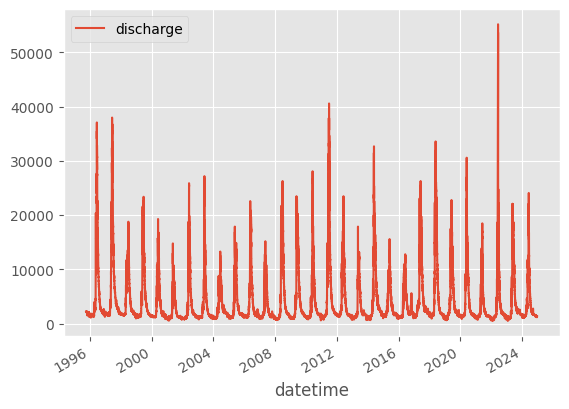

In [135]:
# Convert the discharge column to numeric, coercing errors to NaN
data['discharge'] = pd.to_numeric(data['discharge'], errors='coerce')

# Plot the data
data.plot(x='datetime', y='discharge')

From this chart we can see that there is indeed an increase of discharge every spring.  However, the magnitude of this increase varies quite a bit from year to year.

In [136]:
data['year']=data['datetime'].dt.year

data.head()

,id,datetime,discharge,gage_height,snotel_station_id,snotel_station_name,snow_water_equivalent,wx_station,wx_name,max_temp,min_temp,year
0,6192500,1995-10-01 00:15:00,2210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1995
1,6192500,1995-10-01 00:30:00,2210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1995
2,6192500,1995-10-01 00:45:00,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1995
3,6192500,1995-10-01 01:00:00,2210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1995
4,6192500,1995-10-01 01:15:00,2200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1995


In [137]:
data.groupby(['year']).mean(numeric_only=True)

,id,discharge,snotel_station_id,snow_water_equivalent,max_temp,min_temp
year,,,,,,
1995,6192500.0,1907.679538,671.8,3.926500,6.800625,-4.810127
1996,6192500.0,6757.158670,671.8,8.595512,14.013782,-1.376520
1997,6192500.0,6718.797686,671.8,9.632131,12.942351,-1.431562
1998,6192500.0,4213.337690,671.8,5.348289,12.814414,-1.796402
1999,6192500.0,4370.689390,671.8,7.909191,13.212638,-2.363249
2000,6192500.0,3409.749269,671.8,4.871382,13.310501,-2.597900
2001,6192500.0,2478.280699,671.8,3.614984,13.291667,-2.729667
2002,6192500.0,3742.422129,671.8,4.709165,13.075589,-2.124329
2003,6192500.0,3547.072166,671.8,5.648268,13.910985,-1.666452


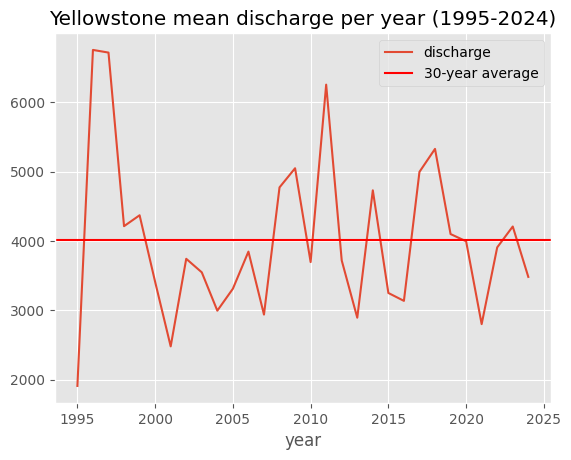

In [138]:
means = data.groupby(['year']).mean(numeric_only=True)
mean_discharge = means['discharge']
overall_mean = mean_discharge.mean()
mean_discharge.plot()
plt.axhline(y=overall_mean, color='red', label='30-year average')
plt.title("Yellowstone mean discharge per year (1995-2024)")
plt.plot(2024, mean_discharge[2024])
plt.legend()

Not only does the magnitude of the spring discharge increase every year, the mean discharge for each year also varies by quite a bit.  This is likely due to the amount of snowpack in the mountains that feed the river.  A potential future question is whether the amount of snowpack can be used to predict the spring discharge increase.  

In [139]:
data['year']

0          1995
1          1995
2          1995
3          1995
4          1995
           ... 
1064197    2024
1064198    2024
1064199    2024
1064200    2024
1064201    2024
Name: year, Length: 1064202, dtype: int32

In [140]:
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['day_of_year'] = data['datetime'].dt.dayofyear

In [141]:
year_2021 = data[data['year'] == 2021]
year_2022 = data[data['year'] == 2022]
year_2023 = data[data['year'] == 2023]
year_2024 = data[data['year'] == 2024]

In [142]:
year_2021

,id,datetime,discharge,gage_height,snotel_station_id,snotel_station_name,snow_water_equivalent,wx_station,wx_name,max_temp,min_temp,year,month,day,day_of_year
913712,6192500,2021-01-01 00:00:00,1330.0,0.83,384.0,Canyon,4.4,USW00024150,"LIVINGSTON AIRPORT, MT US",4.4,-1.0,2021,1,1,1
913713,6192500,2021-01-01 00:00:00,1330.0,0.83,384.0,Canyon,4.4,USC00485345,"LAKE YELLOWSTONE, WY US",-3.3,-14.4,2021,1,1,1
913714,6192500,2021-01-01 00:00:00,1330.0,0.83,670.0,Northeast Entrance,2.9,USW00024150,"LIVINGSTON AIRPORT, MT US",4.4,-1.0,2021,1,1,1
913715,6192500,2021-01-01 00:00:00,1330.0,0.83,670.0,Northeast Entrance,2.9,USC00485345,"LAKE YELLOWSTONE, WY US",-3.3,-14.4,2021,1,1,1
913716,6192500,2021-01-01 00:00:00,1330.0,0.83,683.0,Parker Peak,10.7,USW00024150,"LIVINGSTON AIRPORT, MT US",4.4,-1.0,2021,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951844,6192500,2021-12-31 22:45:00,NaN,-0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,12,31,365
951845,6192500,2021-12-31 23:00:00,NaN,-0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,12,31,365
951846,6192500,2021-12-31 23:15:00,619.0,-0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,12,31,365
951847,6192500,2021-12-31 23:30:00,NaN,-0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,12,31,365


In [143]:
gage_height_2021 = year_2021[['day_of_year', 'gage_height']]
gage_height_2022 = year_2022[['day_of_year', 'gage_height']]
gage_height_2023 = year_2023[['day_of_year', 'gage_height']]
gage_height_2024 = year_2024[['day_of_year', 'gage_height']]

In [144]:
discharge_2021 = year_2021[['day_of_year', 'discharge']]
discharge_2022 = year_2022[['day_of_year', 'discharge']]
discharge_2023 = year_2023[['day_of_year', 'discharge']]
discharge_3_year = discharge_2021.merge(discharge_2022, on='day_of_year').merge(discharge_2023, on='day_of_year')
discharge_3_year.columns = ['day_of_year', 'discharge_2021', 'discharge_2022', 'discharge_2023']

Text(0.5, 0, 'Day of the year')

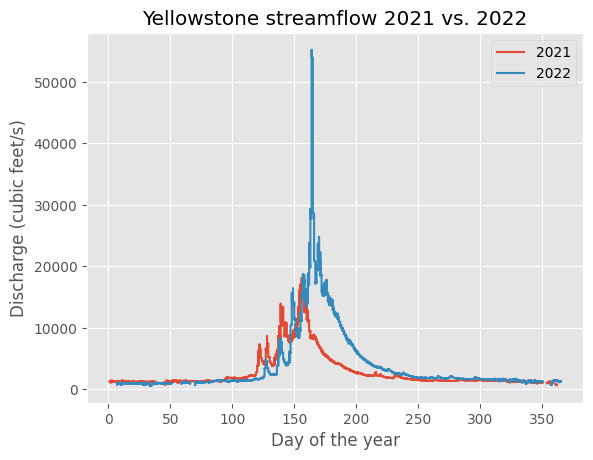

In [145]:
fig, ax = plt.subplots()
ax.plot(discharge_2021['day_of_year'], discharge_2021['discharge'], label='2021')
ax.plot(discharge_2022['day_of_year'], discharge_2022['discharge'], label='2022')
plt.legend()
plt.title('Yellowstone streamflow 2021 vs. 2022')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Day of the year')

This chart examines the 2021 vs the 2022 data.  There is quite a difference between the two.  2021's spring increase started earlier.  2022 had a much higher peak discharge than 2021.  I suspect that the amount of snowpack in the mountains was much less during 2021.  This is a potential future question to investigate.

Text(0.5, 0, 'Day of the year')

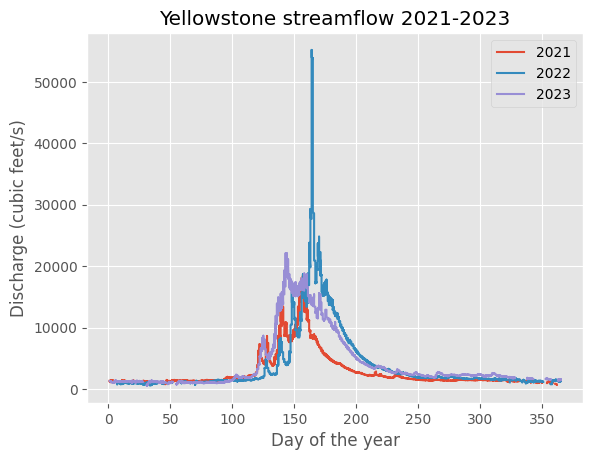

In [146]:
fig, ax = plt.subplots()
ax.plot(discharge_2021['day_of_year'], discharge_2021['discharge'], label='2021')
ax.plot(discharge_2022['day_of_year'], discharge_2022['discharge'], label='2022')
ax.plot(discharge_2023['day_of_year'], discharge_2023['discharge'], label='2023')
plt.legend()
plt.title('Yellowstone streamflow 2021-2023')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Day of the year')

Similar to the previous graph.  2023 data had a similar onset time as 2021.  The peak discharge is slightly more than 2021; bot not anywhere close to 2022.  

In [147]:
discharge=data['discharge'].to_frame()
discharge.index=data['datetime']

Text(0.5, 0, 'Date and Time(15 min intervals)')

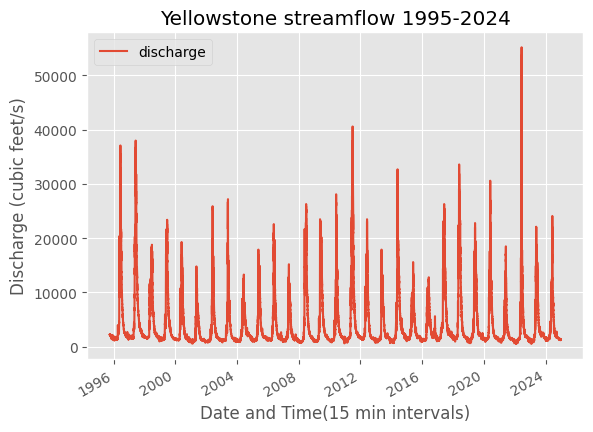

In [148]:

discharge.plot()
plt.title('Yellowstone streamflow 1995-2024')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date and Time(15 min intervals)')

In [149]:
discharge_2008 = discharge[(discharge.index >= '2008-01-01') & (discharge.index < '2009-01-01')]
discharge_2014 = discharge[(discharge.index >= '2014-01-01') & (discharge.index < '2015-01-01')]
discharge_2020 = discharge[(discharge.index >= '2020-01-01') & (discharge.index < '2021-01-01')]

Text(0.5, 0, 'Date')

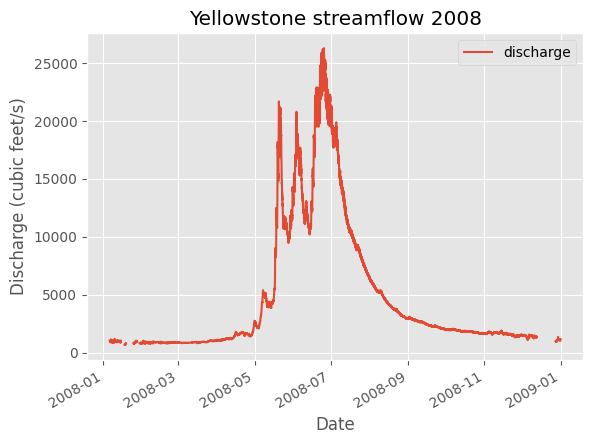

In [150]:
discharge_2008.plot()
plt.title('Yellowstone streamflow 2008')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

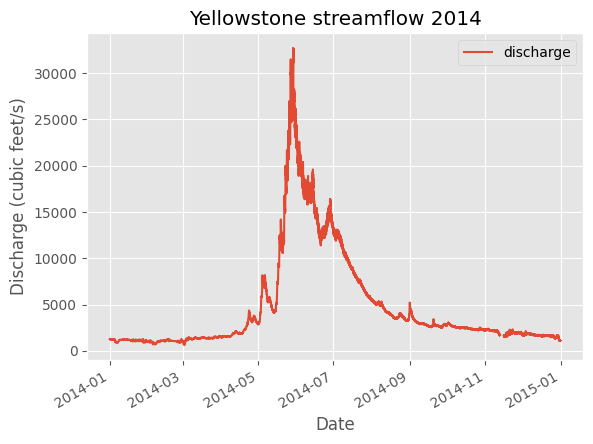

In [151]:
discharge_2014.plot()
plt.title('Yellowstone streamflow 2014')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

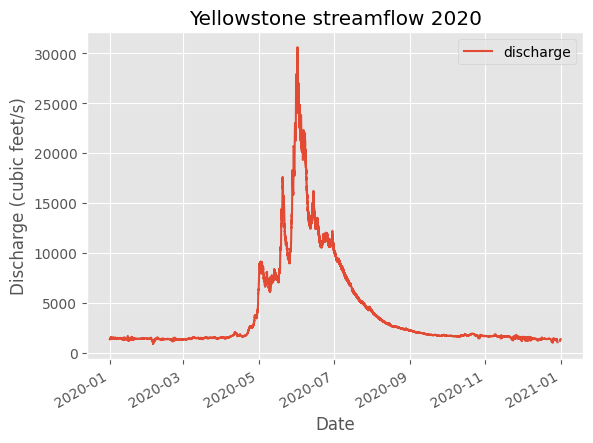

In [152]:
discharge_2020.plot()
plt.title('Yellowstone streamflow 2020')
plt.ylabel('Discharge (cubic feet/s)')
plt.xlabel('Date')

In [153]:
discharge['day_of_year']=discharge.index.day_of_year
discharge['week']=discharge.index.isocalendar().week.astype('int32')
discharge['month']=discharge.index.month
discharge['quarter']=discharge.index.quarter
discharge['year']=discharge.index.year

In [154]:
discharge_consolidated = discharge.copy()
discharge_consolidated = discharge_consolidated.groupby(['year', 'day_of_year']).first()

([<matplotlib.axis.XTick at 0x71676db5d2b0>,
 [Text(0, 0, '1'),
  Text(5, 0, '6'),
  Text(10, 0, '11'),
  Text(15, 0, '16'),
  Text(20, 0, '21'),
  Text(25, 0, '26'),
  Text(30, 0, '31'),
  Text(35, 0, '36'),
  Text(40, 0, '41'),
  Text(45, 0, '46'),
  Text(50, 0, '51')])

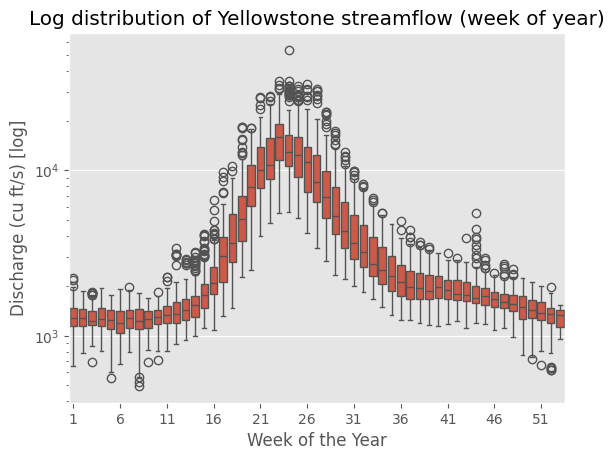

In [155]:
sns.boxplot(data=discharge_consolidated, x='week', y='discharge')
plt.ylabel('Discharge (cu ft/s) [log]')
plt.xlabel('Week of the Year')
plt.yscale('log')
plt.title('Log distribution of Yellowstone streamflow (week of year)')

plt.xticks(range(0, 53, 5))

Box and whisker plots for each week of the year.  There are many outliers during the spring and summer months.  This fits with what we already saw earlier that there is a lot of variability in the peak discharge for a given year.

Text(0.5, 1.0, 'Log distribution of Yellowstone streamflow (month of year)')

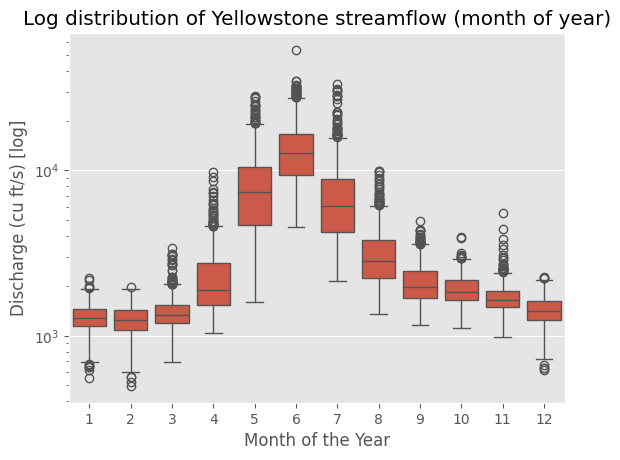

In [156]:
sns.boxplot(data=discharge_consolidated,x='month', y='discharge')
plt.ylabel('Discharge (cu ft/s) [log]')
plt.xlabel('Month of the Year')
plt.yscale('log')
plt.title('Log distribution of Yellowstone streamflow (month of year)')

Similar to the previous plot.  This plot is aggregating the data by month.  We can reach a similar conclusion though.  There is a lot of variability in the peak discharge for a given year.

# Prediction
This is an effort to predict the spring increase in discharge.  The data is from the Yellowstone river at Livingston MT. The data is from the USGS and is available at https://waterdata.usgs.gov/mt/nwis/uv?site_no=06192500   

Ideally we would like to predict both the onset of the spring increase and the peak discharge.   

In [157]:
train = discharge[discharge['year']<2023]
test = discharge[discharge['year']>=2023]

Text(0, 0.5, 'Discharge (cu ft/s)')

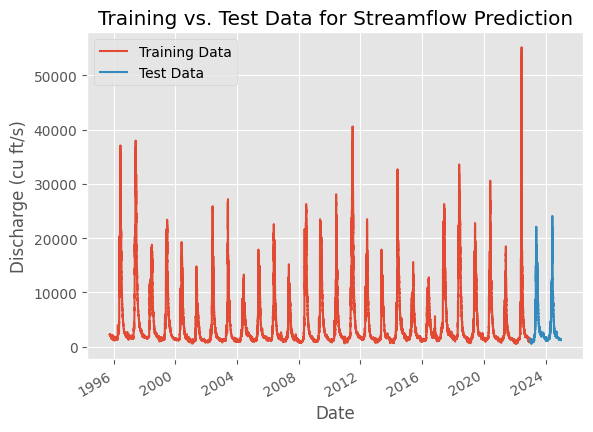

In [158]:
fig, ax = plt.subplots()
train['discharge'].plot(ax=ax)
test['discharge'].plot(ax=ax)
plt.legend(['Training Data', 'Test Data'])
plt.title('Training vs. Test Data for Streamflow Prediction')
plt.xlabel('Date')
plt.ylabel('Discharge (cu ft/s)')

The model will be trained on data from the years preceeding 2023.  The model will be tested on the 2023-2024 data.  

In [159]:
features = ['month','week', 'day_of_year']
target = 'discharge'

x_train = train[features]
y_train = train[target]

x_test = test[features]
y_test = test[target]

In [ ]:
from dask_ml.xgboost import XGBRegressor as DaskXGBRegressor

# Remove NaN values from x_train, y_train, x_test, and y_test
x_train = x_train.dropna()
y_train = y_train.dropna()
x_test = x_test.dropna()
y_test = y_test.dropna()

# Ensure x_train and y_train match the indices
common_index_train = x_train.index.intersection(y_train.index)
x_train = x_train.loc[common_index_train]
y_train = y_train.loc[common_index_train]

# Ensure x_test and y_test match the indices
common_index_test = x_test.index.intersection(y_test.index)
x_test = x_test.loc[common_index_test]
y_test = y_test.loc[common_index_test]

# Align the indices of x_train and y_train
x_train, y_train = x_train.align(y_train, join='inner', axis=0)

# Align the indices of x_test and y_test
x_test, y_test = x_test.align(y_test, join='inner', axis=0)

# Use Dask for memory-efficient data handling
import dask.dataframe as dd

# Convert pandas DataFrames to Dask DataFrames
x_train_dd = dd.from_pandas(x_train, npartitions=10)
y_train_dd = dd.from_pandas(y_train, npartitions=10)
x_test_dd = dd.from_pandas(x_test, npartitions=10)
y_test_dd = dd.from_pandas(y_test, npartitions=10)

# Train the model using Dask

regressor = DaskXGBRegressor(n_estimators=1000, early_stopping_rounds=100)
regressor.fit(x_train_dd, y_train_dd, eval_set=[(x_test_dd, y_test_dd)], verbose=20)

# Train the model
regressor = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=100)
eval_set = [(x_train_sample, y_train_sample), (x_test_sample, y_test_sample)]
regressor.fit(x_train_sample, y_train_sample, eval_set=eval_set, verbose=20)

ModuleNotFoundError: No module named 'dask_xgboost'

In [65]:
pd.set_option('mode.chained_assignment', None)

# Reindex x_test to match the index of test
x_test_reindexed = x_test.reindex(test.index)

# Make predictions
test['prediction'] = regressor.predict(x_test_reindexed)

In [ ]:
importance = pd.DataFrame(data=regressor.feature_importances_, index=regressor.feature_names_in_,
            columns=['importance'])
importance = importance.sort_values('importance')
importance.plot.barh()
plt.title('Feature Importance')

The day of the year is the most important variable in predicting the onset of the discharge.

In [ ]:
predicted_2023 = test[test['year'] == 2023]
predicted_2023.plot(y=['discharge', 'prediction'])
plt.title('Model vs. 2023 Discharge Data')

This is a plot of the model prediction vs the actual 2023 data.  The timing of the onset looks really good.  However, the peak discharge is off a bit.

In [ ]:
predicted_2024 = test[test['year'] == 2024]
predicted_2024.plot(y=['discharge', 'prediction'])
plt.title('Model vs. 2024 Discharge Data')

Like the 2023 data, the model prediction for the 2024 data looks good for the onset of the discharge.  The peak discharge is off a bit again.  It seems that the model is underpredicting the peak discharge.  I suspect that this has something to do with the amount of snowpack in the mountains.  This is a potential future question to investigate.  Average daily temperatures could also be a useful variable to include in the model.  This should be the next step in improving the model.